In [43]:
from Data import *
import Data
from tensorflow.keras import layers
from keras import backend as k
import IPython

import Data
import tensorflow as tf
from sklearn.model_selection import train_test_split

import model
from model import build_model_CNN

from plotter import hist_plotter

import os
from keras.layers import *
from keras import Model


physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Could not initialize the tensorflow gpu')
    pass


In [44]:
from tensorflow_docs.modeling import EpochDots


In [45]:
data_attr = [50, 0]
Features_TrainA, Labels_TrainA, Features_TestA, Labels_TestA = Data.dataset_main(
    data_attr[0], data_attr[1], Accel='Yes')

Features_TrainG, Labels_TrainG, Features_TestG, Labels_TestG = Data.dataset_main(
    data_attr[0], data_attr[1], Accel='No')

Features_TrainA, Features_ValA, Labels_TrainA, Labels_ValA = train_test_split(
    Features_TrainA,
    Labels_TrainA,
    shuffle=True,
    test_size=0.2,
    random_state=42)

Features_TrainG, Features_ValG, Labels_TrainG, Labels_ValG = train_test_split(
    Features_TrainG,
    Labels_TrainG,
    shuffle=True,
    test_size=0.2,
    random_state=42)


Accel
29
Train Labels shape   : (4129, 1)
Train Features shape : (4129, 3, 50, 1)
Test labels shape    : (1033, 1)
Test Features shape  : (1033, 3, 50, 1)
Gyro
29
Train Labels shape   : (4129, 1)
Train Features shape : (4129, 3, 50, 1)
Test labels shape    : (1033, 1)
Test Features shape  : (1033, 3, 50, 1)


In [48]:
def R_Square(y_true, y_pred):

    Num = k.sum(k.square(y_true - y_pred))
    Denom = k.sum(k.square(y_true - k.mean(y_true)))
    R = 1 - Num / (Denom + k.epsilon())
    return R

In [63]:
def conv1(input):
    model = input
    model1 = Conv2D(28, (1,1), padding = 'same')(model)
    model1 = BatchNormalization()(model1)

    model = Conv2D(28, (1,1), padding = 'same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)


    model = Conv2D(28, (3,3), padding = 'same')(model)
    model = BatchNormalization()(model)

    model = Add()([model, model1])

    model = Activation('relu')(model)    
    
    return model

def conv2(model):
    model = MaxPool2D()(model)
    model = tf.squeeze(model, [1])

    model2 = Conv1D(filters = 56,kernel_size = 1, padding ='same')(model)
    model2 = BatchNormalization()(model2)

    model = Conv1D(filters = 56,kernel_size = 1, padding ='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Conv1D(filters = 56,kernel_size = 3, padding ='same')(model)
    model = BatchNormalization()(model)

    model = Add()([model, model2])

    model = Activation('relu')(model)

    return model

def conv3(model, fils, flatten = False):
    model = MaxPool1D()(model)

    model3 = Conv1D(filters = fils,kernel_size = 1, padding ='same')(model)
    model3 = BatchNormalization()(model3)

    model = Conv1D(filters = fils,kernel_size = 1, padding ='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Conv1D(filters = fils,kernel_size = 3, padding ='same')(model)
    model = BatchNormalization()(model)

    model = Add()([model, model3])
    model = Activation('relu')(model)
    
    if flatten:
            model = Flatten()(model)
    
    return model


def conv4(model):
    model = MaxPool1D()(model)
    model = Conv1D(filters = 2,kernel_size = 1, padding ='same')(model)
    model = Flatten()(model)
    return model


def conv1234(model):
    model = conv1(model)
    model = conv2(model)
    model = conv3(model, 128, flatten=False)
    model = conv3(model, 18, flatten= True)
    
   # model = conv4(model)
    return model
    


def build_model_CNN():
    inputA = layers.Input(shape=(3, 50, 1))
    modelA = inputA
    
    modelA = conv1234(modelA)
    
    inputG = layers.Input(shape=(3, 50, 1))
    modelG = inputG

    modelG = conv1234(modelG)

    model = layers.Concatenate()([modelA, modelG])
    print(model.shape)
    model = layers.Dense(120, activation='relu')(model)
    model = layers.Dropout(0.4)(model)
    model = layers.Dense(30, activation='relu')(model)
    model = layers.Dropout(0.4)(model)
    output = layers.Dense(1)(model)

    model = tf.keras.Model(inputs=[inputA, inputG], outputs=output)

    optimizer = tf.keras.optimizers.RMSprop(1e-3)
    optimizer = tf.keras.optimizers.Adam(1e-3)

    loss = tf.keras.losses.Huber()
    loss = tf.keras.losses.LogCosh()
    loss = tf.keras.losses.MeanAbsolutePercentageError()
    loss = tf.keras.losses.MeanSquaredError(reduction="auto",
                                            name="mean_squared_error")
    loss = tf.keras.losses.MeanAbsoluteError(reduction="auto",
                                             name="mean_absolute_error")
    model.compile(
        loss=loss,  #'mean_absolute_error',
        optimizer=optimizer,
        metrics=['mae', 'mape', R_Square])

    tf.keras.utils.plot_model(model,
                              to_file='/home/redev/Pictures/Model.png',
                              show_shapes=True)
    return model



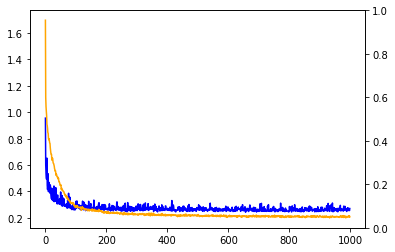

Results of the model training
33/33 [==============================] - 0s 4ms/step - loss: 0.2742 - mae: 0.2742 - mape: 5.7365 - R_Square: 0.8742
[0.27423715591430664, 0.27423715591430664, 5.736546516418457, 0.8742063641548157]


In [64]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)


model = build_model_CNN()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=50)

reduceLRplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       min_lr=1e-6,
                                                       patience=25,
                                                       factor=0.9,
                                                       verbose=1)

if os.path.isdir('logdir'):
    pass
else:
    os.mkdir('logdir')

logdir = 'logdir'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

hist = model.fit([Features_TrainA, Features_TrainG],
                 Labels_TrainA,
                 validation_data=([Features_ValA, Features_ValG], Labels_ValA),
                 epochs=1000,
                 verbose=0,
                 callbacks=[EpochDots(),
                     #earlystopping,
                            #reduceLRplateau, 
                            tensorboard_callback,
                     ClearTrainingOutput()
                 ])

hist_plotter(hist.history)

print("Results of the model training")
print(model.evaluate([Features_TestA, Features_TestG], Labels_TestA))


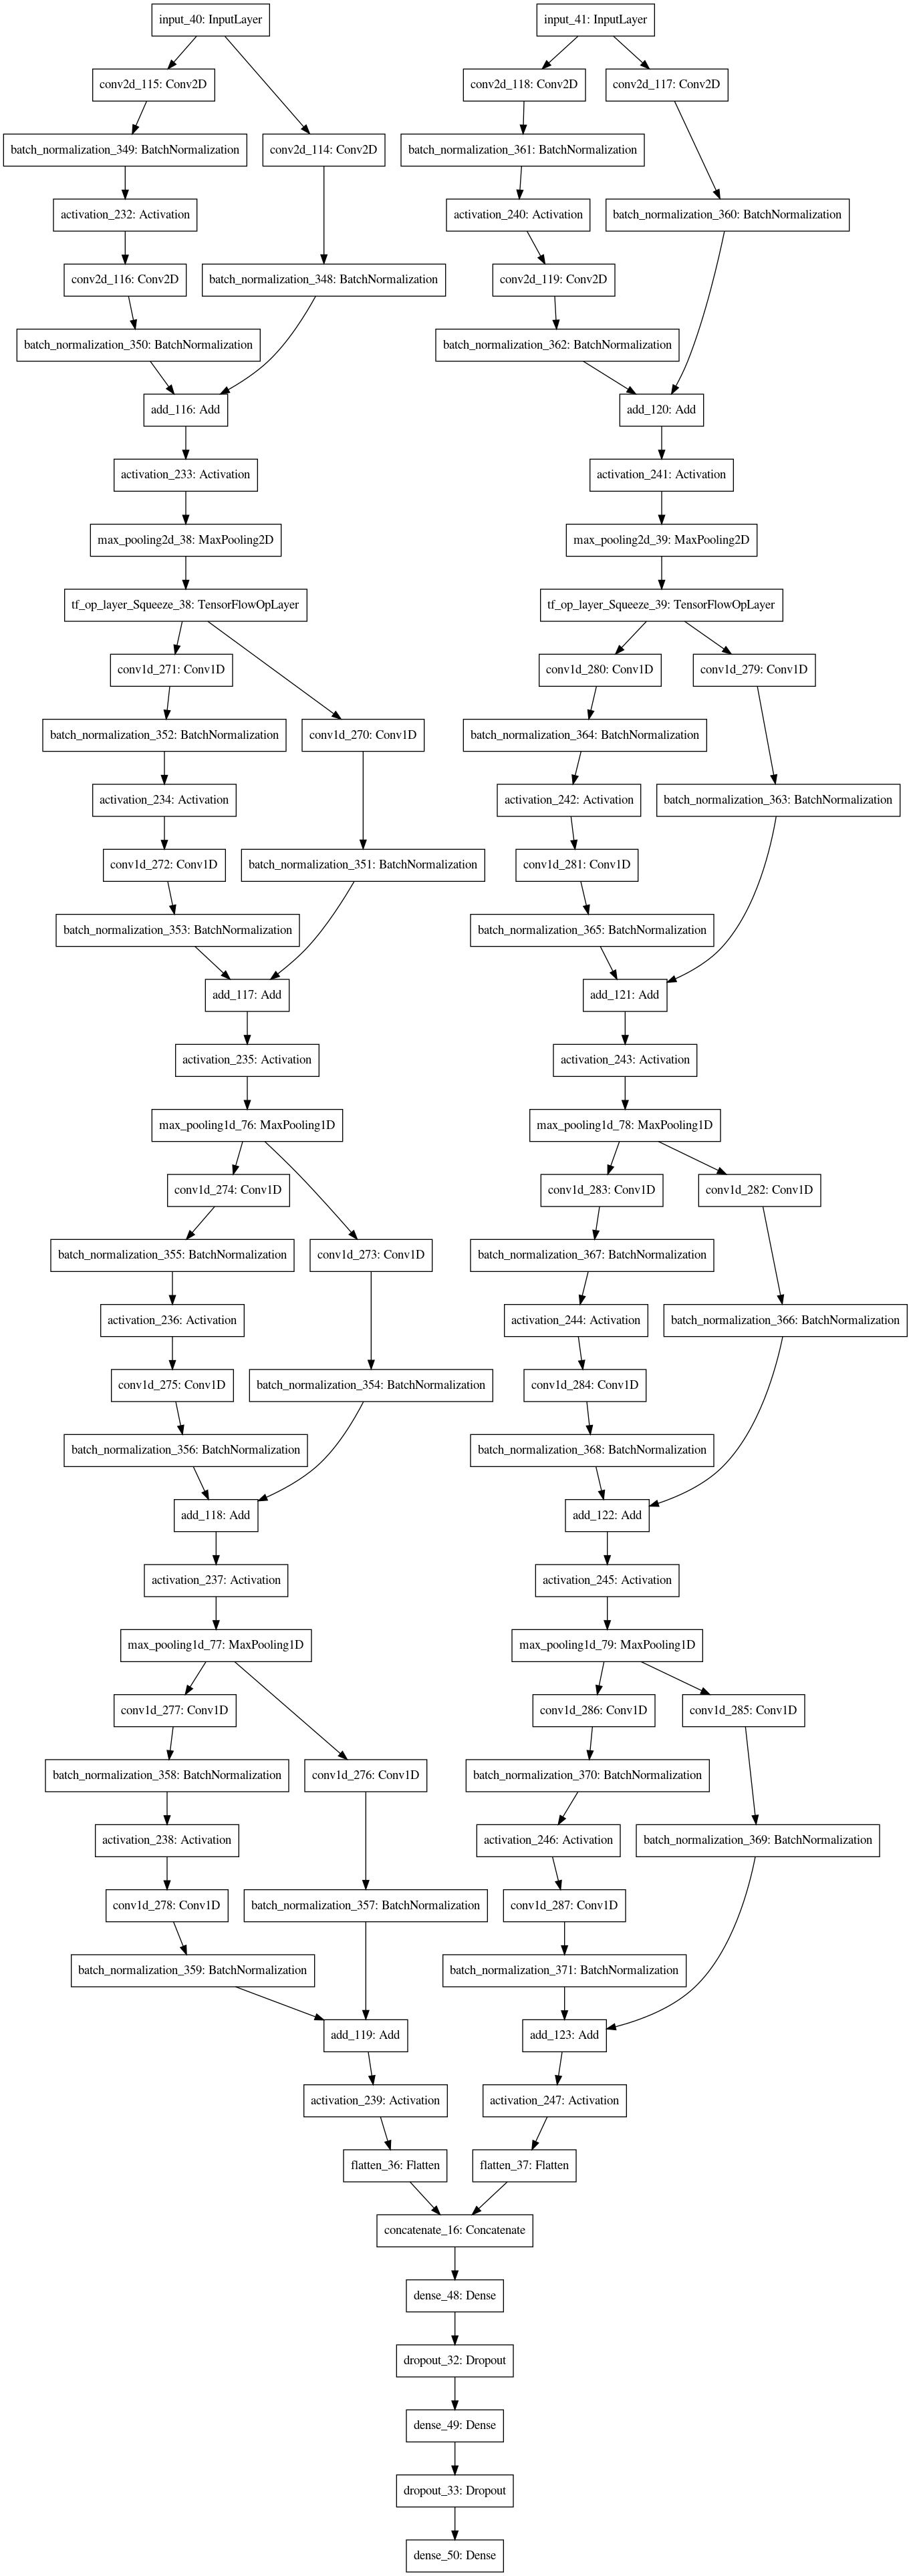

In [65]:
plot_model(model)

In [66]:
from keras.utils import plot_model